In [1]:
import sys
sys.path.append('..')

from tools.siren import *
from tools.table import *

from functools import partial

from scipy import interpolate

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

Initial distribution:
- Number of points (M): 300
- X range: [-4, 4]
- X interval size: 0.026756
- Y-value range: [0.000134, 0.398907]

Selection:
- Selected points (M * 0.95): 285
- Selected x-value range: [-3.812709, 3.785953]
- Selected y-value range: [0.000278, 0.398907]

Final sampling:
- Final points (N): 5000000
- Ratio N/M: 16666.67

Additional Statistics:
X interval size: 0.026756
Selected x-value range: [-3.812709, 3.785953]
Number of unique points sampled: 285
Sampling repetition rate: 99.99%


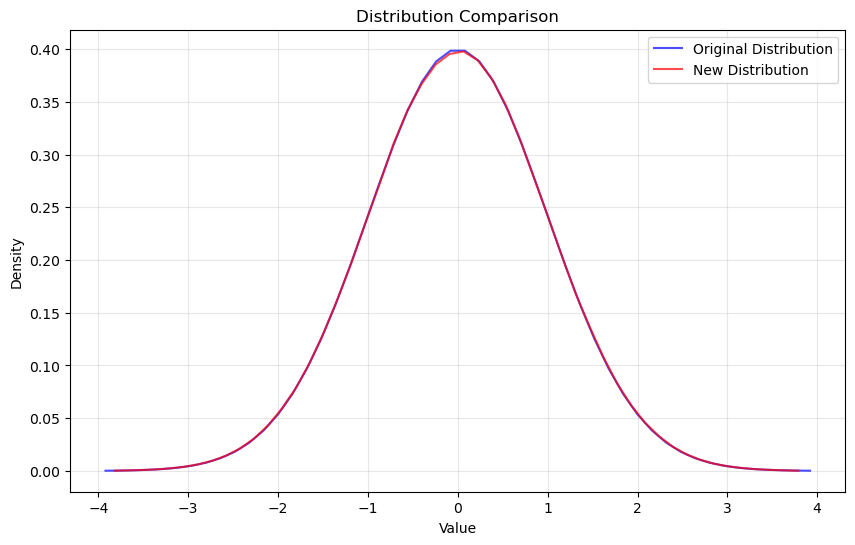

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def generate_constant_interval_sample(n, x_range=(-4, 4)):
    """Generate evenly spaced points along x-axis with their probability density."""
    x = np.linspace(x_range[0], x_range[1], n)
    y = (1 / np.sqrt(2 * np.pi)) * np.exp(-(x ** 2) / 2)
    return x, y

def create_histogram(x, weights=None, bins=50, density=True):
    """Create a normalized histogram from the data."""
    hist, bin_edges = np.histogram(x, bins=bins, weights=weights, density=density)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    return bin_centers, hist

def run_experiment(params):
    """Run the sampling experiment with constant x intervals."""
    # Unpack parameters
    M = params.get('initial_sample_size', 1000)
    N = params.get('final_sample_size', 500000)
    percentile = params.get('percentile', 0.95)
    smearing_sigma = params.get('smearing_sigma', 0.1)
    n_bins = params.get('histogram_bins', 50)
    x_range = params.get('x_range', (-4, 4))
    
    # Generate initial samples with constant intervals
    x_initial, y_initial = generate_constant_interval_sample(M, x_range)
    
    # Use argsort to get indices of top percentile based on y values
    selected_size = int(M * percentile)
    y_indices = np.argsort(y_initial)
    selected_indices = y_indices[-selected_size:]  # Take highest values
    
    x_selected = x_initial[selected_indices]
    y_selected = y_initial[selected_indices]
    
    # Sample N points with repetition from the selected points
    sample_indices = np.random.choice(len(x_selected), size=N, replace=True)
    
    # Apply smearing to the sampled points
    x_new = x_selected[sample_indices] + np.random.normal(0, smearing_sigma, N)
    weights_new = y_selected[sample_indices]
    
    # Print statistics
    print(f"Initial distribution:")
    print(f"- Number of points (M): {M}")
    print(f"- X range: [{x_range[0]}, {x_range[1]}]")
    print(f"- X interval size: {(x_range[1] - x_range[0]) / (M-1):.6f}")
    print(f"- Y-value range: [{y_initial.min():.6f}, {y_initial.max():.6f}]")
    print(f"\nSelection:")
    print(f"- Selected points (M * {percentile}): {selected_size}")
    print(f"- Selected x-value range: [{x_selected.min():.6f}, {x_selected.max():.6f}]")
    print(f"- Selected y-value range: [{y_selected.min():.6f}, {y_selected.max():.6f}]")
    print(f"\nFinal sampling:")
    print(f"- Final points (N): {N}")
    print(f"- Ratio N/M: {N/M:.2f}")
    
    # Create histograms
    bins_original, hist_original = create_histogram(x_initial, weights=y_initial, bins=n_bins)
    bins_new, hist_new = create_histogram(x_new, weights=weights_new, bins=n_bins)
    
    return {
        'original': (bins_original, hist_original),
        'new': (bins_new, hist_new),
        'stats': {
            'x_interval': (x_range[1] - x_range[0]) / (M-1),
            'x_selected_range': (x_selected.min(), x_selected.max()),
            'y_original_range': (y_initial.min(), y_initial.max()),
            'y_selected_range': (y_selected.min(), y_selected.max()),
            'n_selected': selected_size,
            'n_final': N,
            'unique_samples': len(np.unique(sample_indices))
        }
    }

def plot_results(results):
    """Plot the original and new distributions."""
    plt.figure(figsize=(10, 6))
    
    # Plot original distribution
    bins_original, hist_original = results['original']
    plt.plot(bins_original, hist_original, 
             label='Original Distribution', 
             color='blue', alpha=0.7)
    
    # Plot new distribution
    bins_new, hist_new = results['new']
    plt.plot(bins_new, hist_new, 
             label='New Distribution', 
             color='red', alpha=0.7)
    
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title('Distribution Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Example usage
if __name__ == "__main__":
    # Set experiment parameters
    experiment_params = {
        'initial_sample_size': 300,     # Initial points (M)
        'final_sample_size': 5000000,    # Final points (N)
        'percentile': 0.95,             # Keep top 95%
        'smearing_sigma': 0.02,         # Width of Gaussian smearing
        'histogram_bins': 50,           # Number of bins in histogram
        'x_range': (-4, 4)              # Range for x values
    }
    
    # Run experiment
    results = run_experiment(experiment_params)
    
    # Print additional statistics
    stats = results['stats']
    print("\nAdditional Statistics:")
    print(f"X interval size: {stats['x_interval']:.6f}")
    print(f"Selected x-value range: [{stats['x_selected_range'][0]:.6f}, {stats['x_selected_range'][1]:.6f}]")
    print(f"Number of unique points sampled: {stats['unique_samples']}")
    print(f"Sampling repetition rate: {(stats['n_final'] - stats['unique_samples'])/stats['n_final']:.2%}")
    
    # Plot results
    plot_results(results)

In [3]:
from tools.generate import *
from tools.simulation import create_siren_grid
table = Table('cprof_mu_train_10000ev.h5')
table_data = create_siren_grid(table)
siren_model, model_params = load_siren_jax('siren_cprof_mu.pkl')

#Nphot=2_000_000

Nphot=2_000_000

energy = 500

key = random.PRNGKey(0)

key, subkey = random.split(key)
cos_bins, trk_bins, cos_trk_mesh, (x_data, y_data), grid_shape = table_data

# Create the evaluation grid using JAX operations - using efficient meshgrid
energy_interp = jax_linear_interp(x_data, y_data, energy)
cos_mesh, trk_mesh = jnp.meshgrid(cos_bins, trk_bins, indexing='ij')  # Note the indexing='ij'
evaluation_grid = jnp.stack([
    jnp.full_like(cos_mesh, energy_interp).ravel(),
    cos_mesh.ravel(),  # Maintain correct order: cos first
    trk_mesh.ravel(),  # trk second
], axis=1)

# Initialize SIREN model
model = SIREN(
    hidden_features=256,
    hidden_layers=3,
    out_features=1,
    outermost_linear=True
)

# Apply SIREN model
photon_weights, _ = model.apply(model_params, evaluation_grid)

# After getting selected_cos and selected_trk:
key, sampling_key = random.split(key)
key, noise_key_cos = random.split(key)
key, noise_key_trk = random.split(key)

# this calculate the number of good seeds based on linear
# interpolation given the trained SIREN model under evaluation
# with the specific grid settings in create_siren_grid
# if you change create_siren_grid, change also the numbers below.
# you can use code in siren/cut_off_study notebook.
#num_seeds =jnp.int32(energy*14.98321429-2824.21428571) # using 200 x 200 binning
num_seeds = jnp.int32(energy*94.14714286-17750.)
#num_seeds = jnp.int32(energy*.44142857-77.85714286)     # using 50 x 50 binning

#num_seeds=250

print(num_seeds)
seed_indices = random.randint(sampling_key, (Nphot,), 0, num_seeds)
print(num_seeds)
#seed_indices = random.randint(sampling_key, (Nphot,), 0, 2500)

indices_by_weight = jnp.argsort(-photon_weights.squeeze())[seed_indices]

cos_trk_mesh = jnp.array(cos_trk_mesh)
selected_cos_trk = cos_trk_mesh[indices_by_weight]

# Split into separate cos and trk arrays
sampled_cos = selected_cos_trk[:, 0]
sampled_trk = selected_cos_trk[:, 1]

# Add Gaussian noise
# You can adjust the standard deviation (sigma) as needed
sigma_cos = 0.001  # example value
sigma_trk = 0.001 # example value

noise_cos = random.normal(noise_key_cos, (Nphot,)) * sigma_cos
noise_trk = random.normal(noise_key_trk, (Nphot,)) * sigma_trk

smeared_cos = sampled_cos + noise_cos
smeared_trk = sampled_trk + noise_trk

# kill those events sampled outside of the normalized SIREN binning
# the sigma and binning are chosen such that the fraction of those events is negligibly small.
smeared_trk = jnp.where(smeared_trk<-1, 0, smeared_trk)
smeared_trk = jnp.where(smeared_trk> 1, 0, smeared_trk)

smeared_cos = jnp.where(smeared_cos<-1, 0, smeared_cos)
smeared_cos = jnp.where(smeared_cos> 1, 0, smeared_cos)


# Create new evaluation grid with smeared values
energy_interp = jax_linear_interp(x_data, y_data, energy)
A_grid = jnp.stack([
    jnp.full_like(smeared_cos, energy_interp),
    smeared_cos,
    smeared_trk,
], axis=1)

# Run the model with new grid
A_weights, _ = model.apply(model_params, A_grid)

29323
29323


In [4]:
siren_light_profile, siren_params = load_siren_jax('siren_cprof_mu.pkl')

ene_bins = table.normalize(0, table.binning[0])
linear_interpolator = interpolate.interp1d(table.binning[0], ene_bins, kind='linear')

cos_bins = table.normalize(1, np.linspace(0.3, max(table.binning[1]), 400))
trk_bins = table.normalize(2, np.linspace(min(table.binning[2]), 400, 400))

B_grid = jnp.array(np.array([[linear_interpolator(energy), x, y] for x in cos_bins for y in trk_bins]))
B_weights, _ = siren_light_profile.apply(siren_params, B_grid)

In [5]:
B_weights = jnp.where(B_weights>0.01, B_weights, 0)

In [6]:
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def compare_distributions(A_grid, A_weights, B_grid, B_weights):
    """
    Compare two weighted point distributions in 3D space (with constant X).
    
    Parameters:
    - A_grid: jax array of shape (N, 3) for first distribution
    - A_weights: jax array of shape (N, 1) for first distribution weights
    - B_grid: jax array of shape (M, 3) for second distribution
    - B_weights: jax array of shape (M, 1) for second distribution weights
    """
    # Convert to numpy and extract Y,Z coordinates
    A_yz = np.array(A_grid[:, 1:])  # Only Y and Z coordinates
    B_yz = np.array(B_grid[:, 1:])
    A_w = np.array(A_weights).flatten()
    B_w = np.array(B_weights).flatten()
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(10, 3))

    stats_dict = {
        'A_mean': np.average(A_yz, weights=A_w, axis=0),
        'B_mean': np.average(B_yz, weights=B_w, axis=0),
        'A_std': np.sqrt(np.average((A_yz - np.average(A_yz, weights=A_w, axis=0))**2, weights=A_w, axis=0)),
        'B_std': np.sqrt(np.average((B_yz - np.average(B_yz, weights=B_w, axis=0))**2, weights=B_w, axis=0)),
        'A_range': np.ptp(A_yz, axis=0),
        'B_range': np.ptp(B_yz, axis=0)
    }
    
    # KS test for each dimension
    ks_y = stats.ks_2samp(A_yz[:, 0], B_yz[:, 0])
    ks_z = stats.ks_2samp(A_yz[:, 1], B_yz[:, 1])
    
    # # Print statistical results
    # print("\nStatistical Analysis:")
    # print(f"Mean A (Y,Z): {stats_dict['A_mean']}")
    # print(f"Mean B (Y,Z): {stats_dict['B_mean']}")
    # print(f"Std A (Y,Z): {stats_dict['A_std']}")
    # print(f"Std B (Y,Z): {stats_dict['B_std']}")

    c1 = 'navy'
    c2 = 'darkorange'
    alpha = 0.5
    
    ax1 = fig.add_subplot(121)
    # Create filled histograms
    # ax1.hist(A_yz[:, 0], bins=150, weights=A_w, alpha=alpha, color=c1, density=True, label='Sampled')
    # ax1.hist(B_yz[:, 0], bins=200, weights=B_w, alpha=alpha, color=c2, density=True, label='SIREN')
    
    # Add step lines on top
    # Calculate histogram data for lines
    counts_A1, bins_A1, _ = ax1.hist(A_yz[:, 0], bins=800, weights=A_w, density=True, alpha=0)
    counts_B1, bins_B1, _ = ax1.hist(B_yz[:, 0], bins=200, weights=B_w, density=True, alpha=0)
    
    # Plot lines using step
    ax1.step(bins_A1[:-1], counts_A1, where='post', color=c1, linewidth=2, alpha=1, label='Sampled')
    ax1.step(bins_B1[:-1], counts_B1, where='post', color=c2, linewidth=2, alpha=1, label='SIREN')
    ax1.set_xlim(0.6,1.0)
    ax1.set_xlabel('Angle normalized binning')
    ax1.set_ylabel('normalized counts')
    ax1.legend()
    
    ax2 = fig.add_subplot(122)
    # Create filled histograms
    # ax2.hist(A_yz[:, 1], bins=200, weights=A_w, alpha=alpha, color=c1, density=True, label='Sampled')
    # ax2.hist(B_yz[:, 1], bins=200, weights=B_w, alpha=alpha, color=c2, density=True, label='SIREN')
    
    # Add step lines on top
    # Calculate histogram data for lines
    counts_A2, bins_A2, _ = ax2.hist(A_yz[:, 1], bins=300, weights=A_w, density=True, alpha=0)
    counts_B2, bins_B2, _ = ax2.hist(B_yz[:, 1], bins=200, weights=B_w, density=True, alpha=0)
    
    # Plot lines using step
    ax2.step(bins_A2[:-1], counts_A2, where='post', color=c1, linewidth=2, alpha=1, label='Sampled')
    ax2.step(bins_B2[:-1], counts_B2, where='post', color=c2, linewidth=2, alpha=1, label='SIREN')
    ax2.set_xlim(-1.2,-0.2)
    ax2.set_xlabel('Track $s$ normalized binning')
    ax2.set_ylabel('normalized counts')
    ax2.legend()


    plt.tight_layout()
    fig.savefig('phot_gen_1D_dist.pdf')

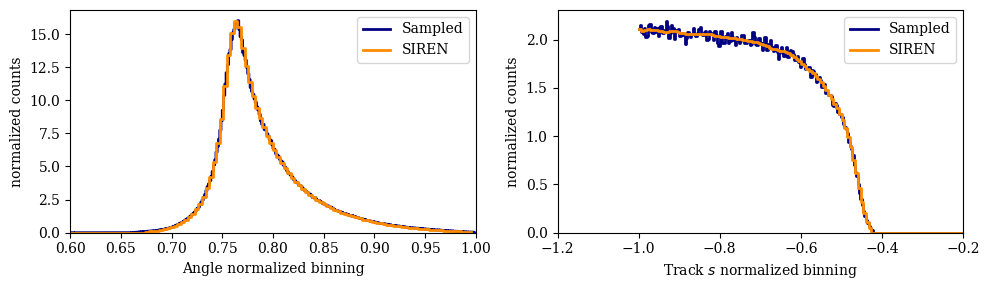

In [8]:
compare_distributions(A_grid, A_weights, B_grid, B_weights)